In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.titlesize'] = 8



In [2]:
images = glob.glob('./samples/*.jpg')
print (images)

data = []
for image in images:
    img = mpimg.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    data.append(img)

data = np.array(data)

['./samples/pipette_tip.jpg', './samples/image2.jpg', './samples/droplet_up_nolabel.jpg', './samples/image1.jpg', './samples/image_.5mm.jpg', './samples/bg_nolbl.jpg', './samples/pipette_tip_nolbl.jpg', './samples/droplet_zoomed_out.jpg', './samples/imagex.jpg', './samples/image.jpg', './samples/full_droplet_1.jpg', './samples/full_droplet_2.jpg', './samples/bg.jpg']


### Lets load all the images to get an idea of the droplets. 

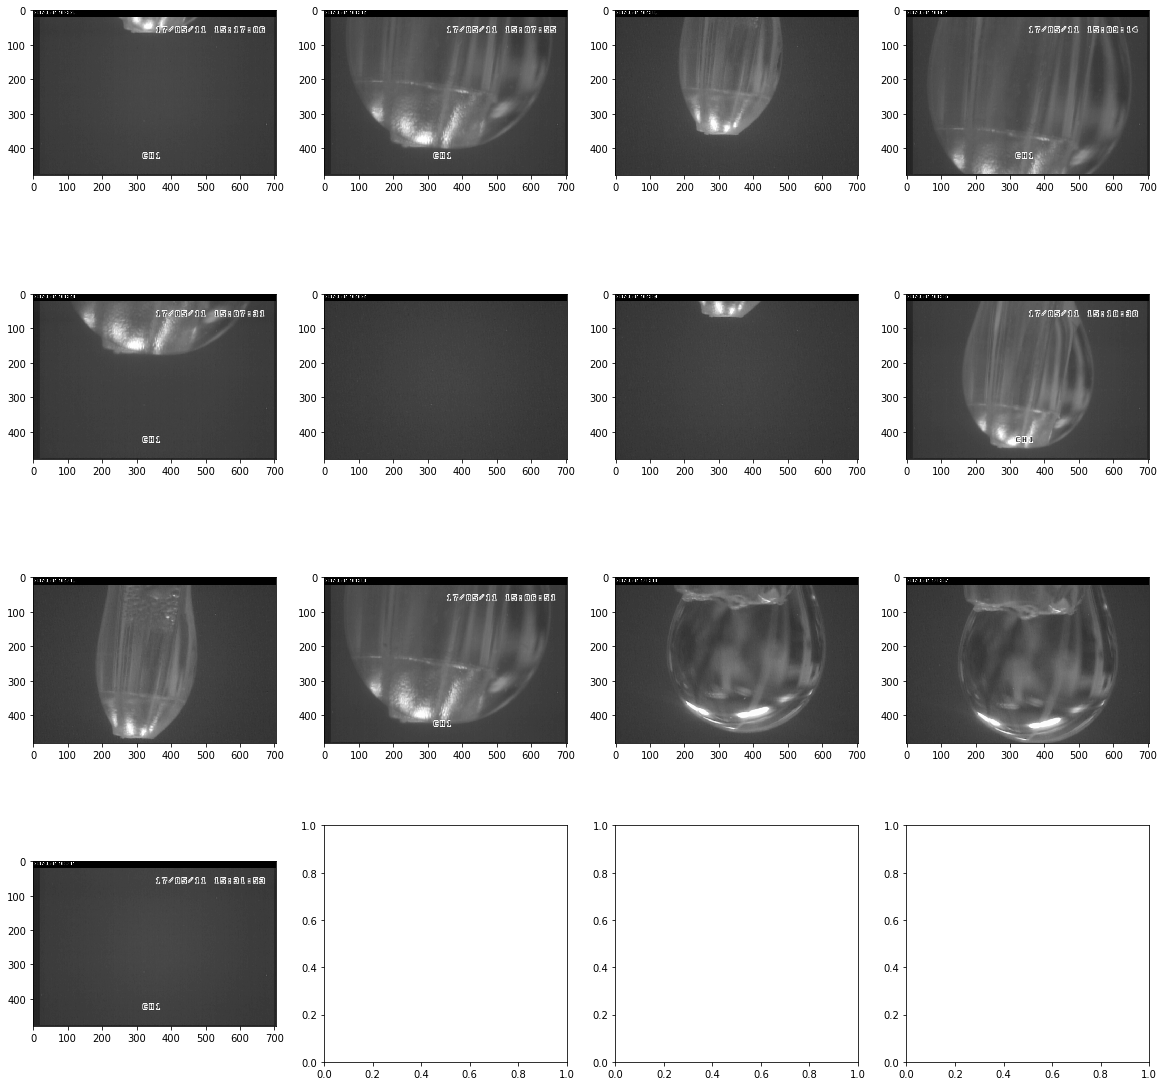

In [3]:
def plot(images):
    rows = int(np.ceil(images.shape[0] / 4))
    cols = 4
    f, ax = plt.subplots(rows, cols, figsize=(20, 20))

    i=0
    j=0
    for img in data:
        ax[i, j].imshow(img, cmap='gray')
        j = j + 1
        if j == cols:
            i = i + 1
            j = 0

plot(data)

### Plotting the histograms will give us some further idea of distribution of pixels between a pure droplet image and anything that might have some droplet visible. 

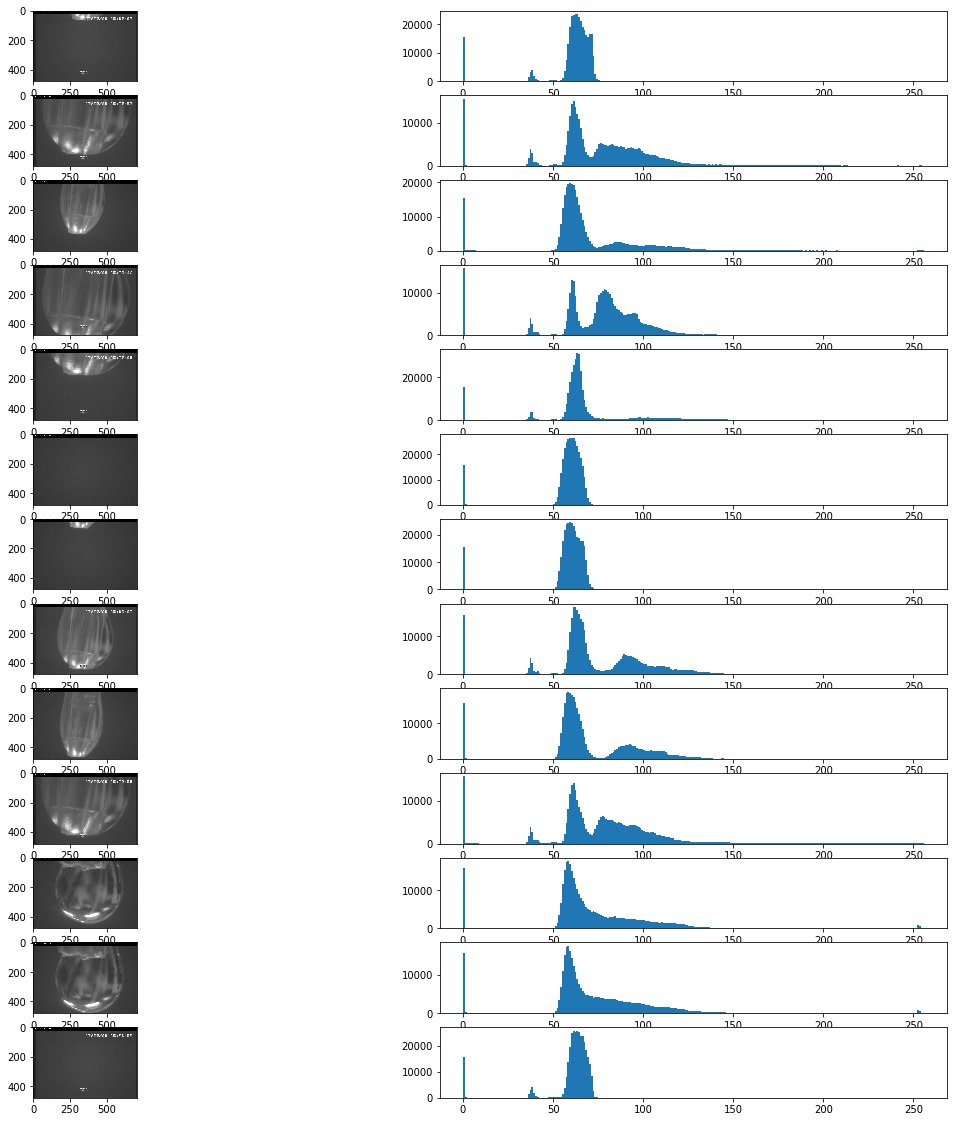

In [4]:
f, ax = plt.subplots(13, 2, figsize=(20, 20))

i=0
for img in data:
    ax[i, 0].imshow(img, cmap='gray')
    ax[i, 1].hist(img.ravel(), 256, [0, 256])
    i = i + 1

### The background seems to be a dominent part of the image. lets try to remove the background from the image. 


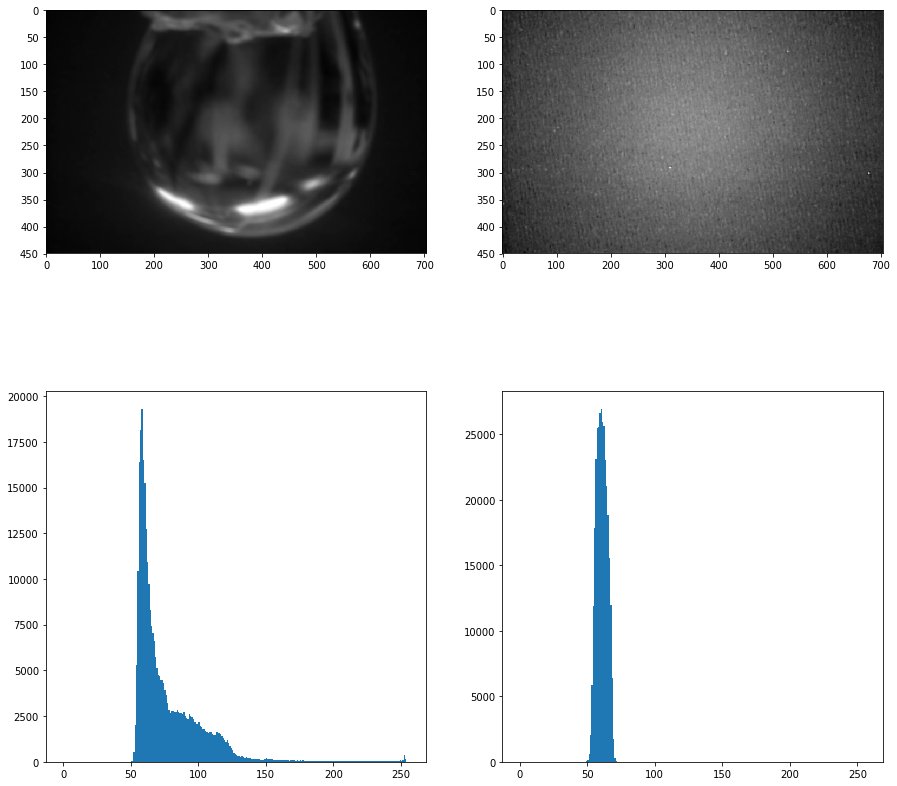

In [15]:
bg = cv2.imread('./samples/bg_nolbl.jpg', 0) 
droplet = cv2.imread('./samples/full_droplet_1.jpg', 0)

# crop the top
bg = bg[30:, :]
droplet = droplet[30:, :]

droplet = cv2.blur(droplet, ksize=(9,9))
bg = cv2.blur(bg, ksize=(3,3))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

ax1.imshow(droplet)
ax2.imshow(bg)
ax3.hist(droplet.ravel(), 256, [0, 256])
ax4.hist(bg.ravel(), 256, [0, 256])

plt.show()

### Attempt # 1

Subtract the background from the image and detect contours. 

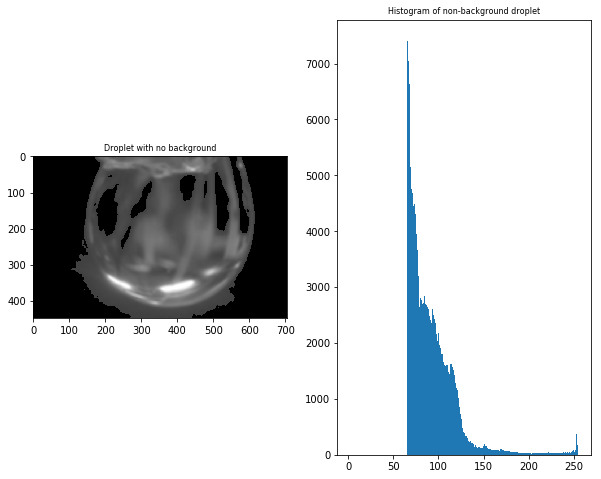

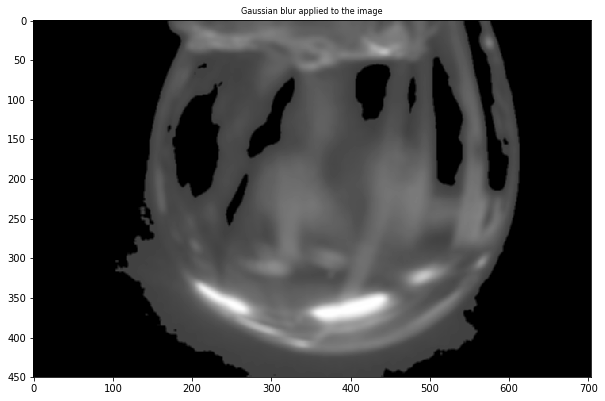

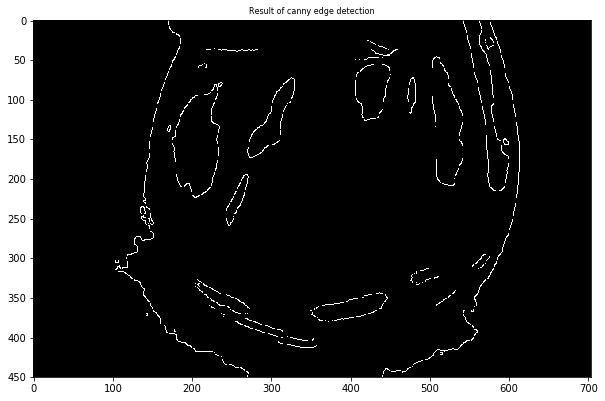

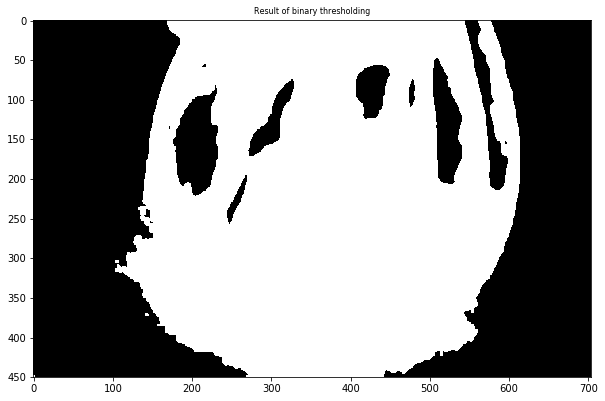

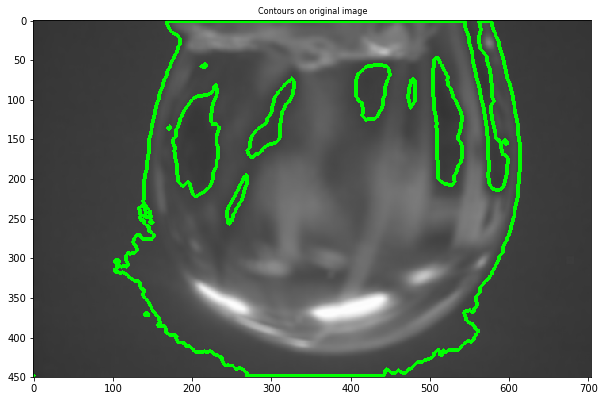

In [16]:
mask = np.zeros_like(droplet)
mask[(droplet < 50) | (droplet >=65)] = 255
masked = cv2.bitwise_and(droplet, mask)

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(masked)
ax1.set_title('Droplet with no background')
ax2.hist(masked.ravel(), 255, [1, 256])
ax2.set_title('Histogram of non-background droplet')
plt.show()

result = cv2.blur(masked, ksize=(3,3))
plt.imshow(result)
plt.title('Gaussian blur applied to the image')
plt.show()

canny_low_thresh = 5
canny_high_thresh = 75
edges = cv2.Canny(result, canny_low_thresh, canny_high_thresh)

plt.figure()
plt.title('Result of canny edge detection')
plt.imshow(edges, cmap='gray')
plt.show()

low_thresh  = 1
high_thresh = 20
ret, binary = cv2.threshold(result, low_thresh, high_thresh, 0)

plt.figure()
plt.imshow(binary, cmap='gray')
plt.title('Result of binary thresholding')
plt.show()

im2, contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
segmented_img = np.dstack((droplet, droplet, droplet))
cv2.drawContours(segmented_img, contours, -1, (0, 255, 0), 3)

plt.figure()
plt.title('Contours on original image')
plt.imshow(segmented_img)
plt.show()
